In [1]:
import math
from tqdm import tqdm
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

from typing import Union, Tuple, List, Optional, Callable, Any
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

import sys
from pathlib import Path
# Go up one level from training_scripts/ to the project root
project_root = Path().resolve().parent
sys.path.append(str(project_root))

%load_ext autoreload
%autoreload 2

from smc.smc import sequential_monte_carlo
from smc.sampling_algorithms import (
    systematic_resample,
    stratified_resample,
    multinomial_resample
)
from smc.utils import lambda_schedule
from datasets import gaussian_mixture

from smc_scripts.plot_utils import plot_smc_results_checkerboard
from smc.proposals import (
    reverse_as_proposal, 
    first_order_approximation_optimal_proposal, 
    first_order_approximation_optimal_proposal_with_gradient_clipping
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import torch
import random
import torch.backends.cudnn as cudnn

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(42)

Using device: cuda


## Load pre-trained mdm model

In [2]:
from models.discrete_diffusion.mdm import MaskedDiffusion
from models.discrete_diffusion.utils.parametrizations import (
    subs_parametrization,
    subs_parametrization_continuous,
)
from models.denoising_models.mlp import MLP

batch_size = 64
vocab_size = 64
num_categories = vocab_size + 1  #includes the mask category
mask_index = num_categories - 1
input_shape = (2,)
num_timesteps = 100

pretrained_model = MaskedDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=64,
        encode_time=False,
        n_hidden_layers=2,
        probs_parametrization_fn=subs_parametrization,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
pretrained_model.load_state_dict(torch.load('../model_weights/mdm_gmm_type1_64.pth'))

pretrained_model_with_subs_continuous = MaskedDiffusion(
    denoising_model=MLP(
        input_shape=input_shape,
        num_categories=num_categories,
        embed_dim=64,
        hidden_dim=64,
        encode_time=False,
        n_hidden_layers=2,
        probs_parametrization_fn=subs_parametrization_continuous,
    ),
    num_categories=num_categories,
    input_shape=input_shape,
    mask_index=mask_index,
    masking_schedule="linear",
    num_timesteps=num_timesteps,
    discretization_schedule="linear",
).to(device)

# load model weights
pretrained_model_with_subs_continuous.load_state_dict(torch.load('../model_weights/mdm_gmm_type1_64.pth'))

<All keys matched successfully>

## Define Reward, KL penalty coefficient, and Corresponding Target Distribution

In [3]:
def compute_rewards(x: Tensor, with_grad=False):
    # x.shape : (B, 2, num_categories)
    
    x0 = torch.arange(0, vocab_size, device=x.device).float() / (vocab_size - 1)
    x1 = torch.arange(0, vocab_size, device=x.device).float() / (vocab_size - 1)
    
    reward_x0 = - ((x0 - 0.5) * 12) ** 2 / 100
    reward_x1 = - ((x1 - 0.5) * 12) ** 2 
    
    reward = (x[:, 0, :-1] * reward_x0 + x[:, 1, :-1] * reward_x1).sum(dim=-1)
    return reward

kl_weight = 1.

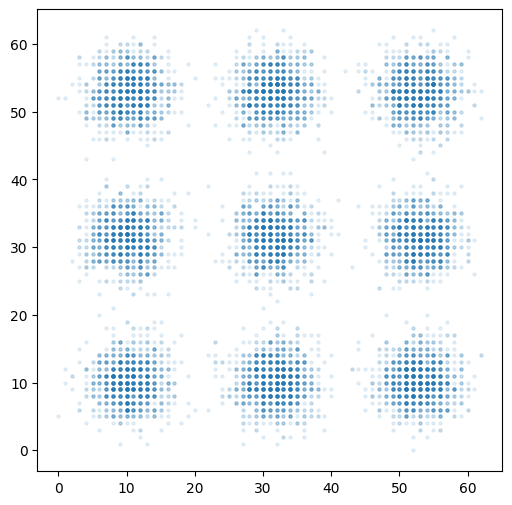

Pre-trained distribution Reward: -11.580293655395508


In [4]:
# Visualize pre-trained model samples
pretrained_model.eval()
with torch.no_grad():
    samples = pretrained_model.sample(num_samples=10000, device=device).cpu().numpy()
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.1)
plt.show()

rewards = compute_rewards(F.one_hot(torch.from_numpy(samples), num_classes=num_categories).float())
print(f"Pre-trained distribution Reward: {rewards.mean().item()}")

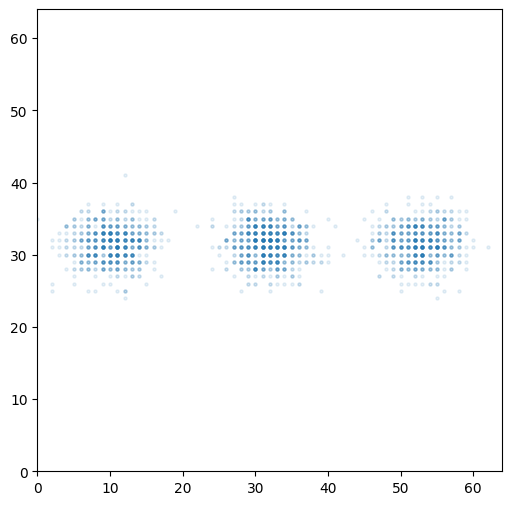

Target Reward: -0.3040497899055481
Diversity: 432


In [5]:
def target_distribution_log_pdf(x, kl_weight):
    reward = compute_rewards(F.one_hot(x, num_classes=num_categories).float())
    return reward / kl_weight

def sample_target_distribution(n_samples, kl_weight):
    samples = gaussian_mixture.generate_samples(type="1", n_grid_points=vocab_size, batch_size=n_samples * 100)
    log_pdf_values = target_distribution_log_pdf(samples, kl_weight)
    indices = torch.distributions.Categorical(logits=log_pdf_values).sample((n_samples,))
    return samples[indices]

target_samples = sample_target_distribution(2000, kl_weight)

plt.figure(figsize=(6, 6))
plt.scatter(target_samples[:, 0], target_samples[:, 1], s=5, alpha=0.1)
plt.xlim(0, vocab_size)
plt.ylim(0, vocab_size)
plt.show()

target_rewards = compute_rewards(F.one_hot(target_samples, num_classes=num_categories).float())
print(f"Target Reward: {target_rewards.mean().item()}")
print(f"Diversity: {np.unique(target_samples, axis=0).shape[0]}")

In [6]:
def intialize_particles(num_particles, device=device):
    particles = torch.full((num_particles, *input_shape), mask_index, device=device, requires_grad=False)
    return particles

num_particles = 2000
ESS_min = num_particles / 2
reward_estimate_sample_count = 100
lambdas = lambda_schedule(num_timesteps)

## Locally Optimal proposal

In [7]:
def compute_reward_for_x0_pred(x_0_probs: Tensor, reward_estimate_sample_count: int):
    N, L, C = x_0_probs.shape
    # Shape: (reward_estimate_sample_count, N, L)
    x_0_preds = torch.distributions.Categorical(x_0_probs).sample((reward_estimate_sample_count,))
    rewards = compute_rewards(
        F.one_hot(x_0_preds.reshape(reward_estimate_sample_count * N, -1), num_classes=num_categories).float()
    ).view(reward_estimate_sample_count, N).mean(dim=0)
    return rewards

def locally_optimal_proposal(X_t, x_s_probs, t, lambdas, kl_weight, rewards_grad, model, reward_estimate_sample_count) -> tuple[Tensor, Tensor]:
    """
    Returns:
        tuple[Tensor, Tensor]: A tuple containing the proposed samples and their log probabilities.
    """
    N = len(X_t)
    
    if not hasattr(locally_optimal_proposal, "all_rewards"):
        all_rewards = torch.zeros(vocab_size + 1, vocab_size + 1, device=device)
        # Both variables are unmasked, x0_pred is fixed
        fixed = torch.stack(torch.meshgrid(torch.arange(vocab_size), torch.arange(vocab_size), indexing='ij'), dim=-1)
        all_rewards[:vocab_size, :vocab_size] = compute_rewards(F.one_hot(fixed.reshape(-1, 2), num_classes=num_categories).float()).reshape(vocab_size, vocab_size)
        locally_optimal_proposal.all_rewards = all_rewards
    else:
        all_rewards = locally_optimal_proposal.all_rewards
    
    if t-1 != 0:
        # variable 0 unmasked, variable 1 masked
        with torch.no_grad():
            _, x_0_probs = model.sample_step(
                F.one_hot(torch.stack([torch.arange(vocab_size + 1, device=device), torch.full((vocab_size + 1,), mask_index, device=device)], dim=1), num_classes=num_categories).float(), 
                t-1, device=device)
        rewards = compute_reward_for_x0_pred(x_0_probs, reward_estimate_sample_count=reward_estimate_sample_count)
        all_rewards[:vocab_size + 1, mask_index] = rewards
        # variable 0 masked, variable 1 unmasked
        with torch.no_grad():
            _, x_0_probs = model.sample_step(
                F.one_hot(torch.stack([torch.full((vocab_size,), mask_index, device=device), torch.arange(vocab_size, device=device)], dim=1), num_classes=num_categories).float(), 
                t-1, device=device)
        rewards = compute_reward_for_x0_pred(x_0_probs, reward_estimate_sample_count=reward_estimate_sample_count)
        all_rewards[mask_index, :vocab_size] = rewards
        
    log_joint = torch.log(x_s_probs[:, 0, :].unsqueeze(2)) + torch.log(x_s_probs[:, 1, :].unsqueeze(1))
    log_joint += (lambdas[t-1] / kl_weight) * all_rewards.unsqueeze(0)
    log_joint -= torch.logsumexp(log_joint, dim=(1, 2), keepdim=True)
    
    indices = torch.multinomial(torch.exp(log_joint).reshape(N, -1), 1)
    X_s  = torch.cat([indices // (vocab_size + 1), indices % (vocab_size + 1)], dim=1)
    log_prob_proposal = log_joint[torch.arange(N), X_s[:, 0], X_s[:, 1]]
    
    return X_s, log_prob_proposal

In [8]:
X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=ESS_min,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=locally_optimal_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=reward_estimate_sample_count,
    device=device,
    verbose=False,
)

100%|██████████| 100/100 [00:03<00:00, 25.82it/s]

Resampled 2 times.


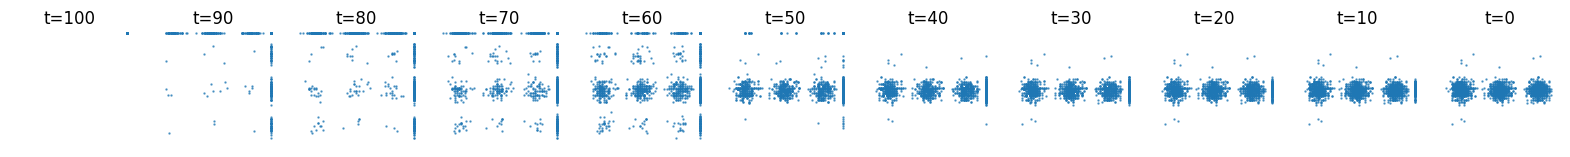

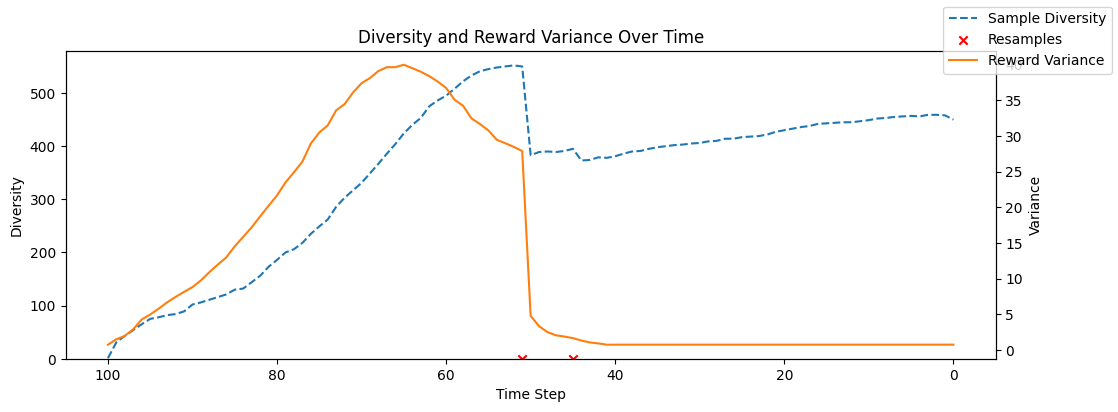

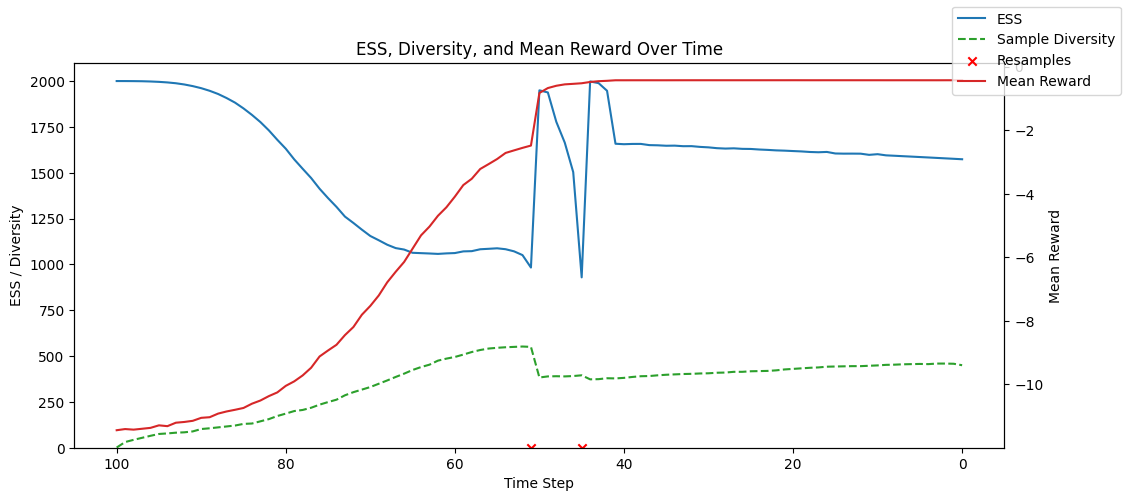

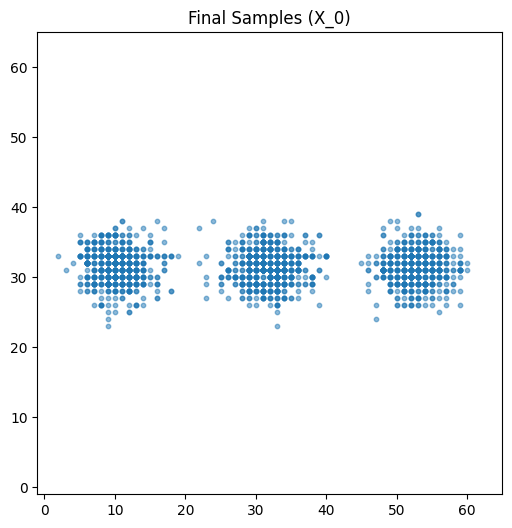

Final average reward: -0.3111
Final diversity: 403


In [9]:
plot_smc_results_checkerboard(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)

## Reverse diffusion as proposal

In [10]:
X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=ESS_min,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=reverse_as_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=reward_estimate_sample_count,
    device=device,
    verbose=False,
)

100%|██████████| 100/100 [00:02<00:00, 44.64it/s]

Resampled 14 times.


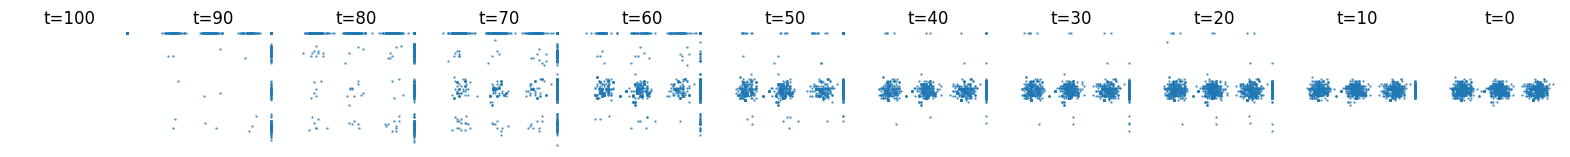

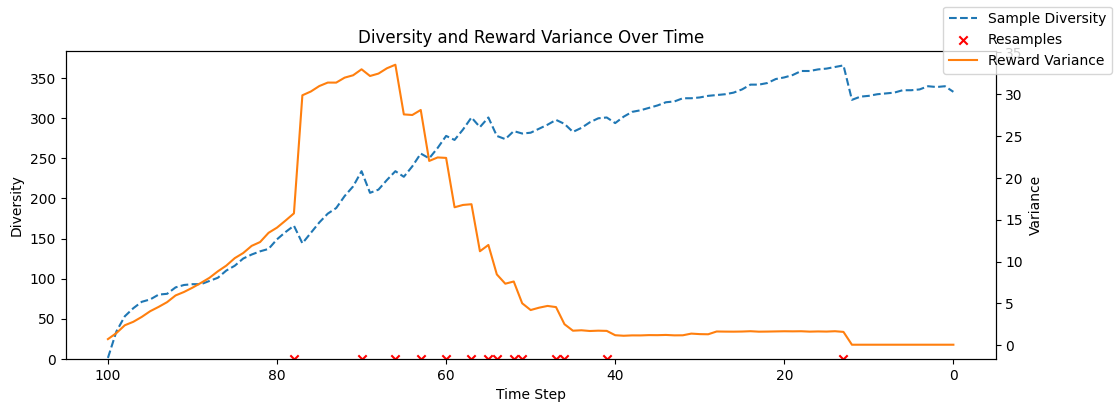

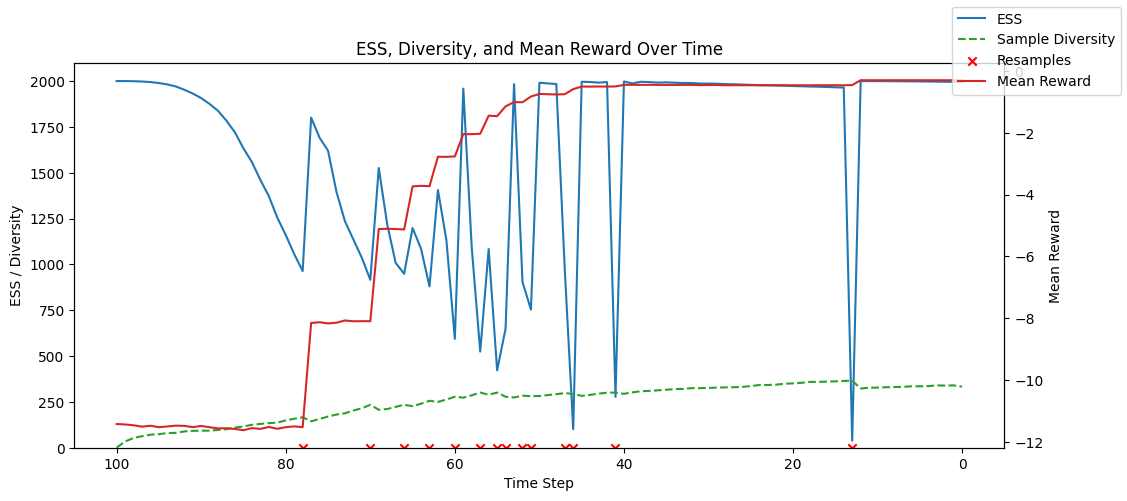

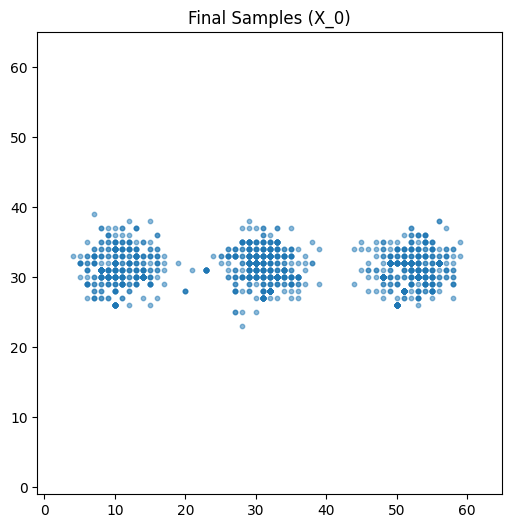

Final average reward: -0.2909
Final diversity: 326


In [11]:
plot_smc_results_checkerboard(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)

## First order approximate proposal

In [12]:
X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=ESS_min,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=first_order_approximation_optimal_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=reward_estimate_sample_count,
    device=device,
    verbose=False,
)

100%|██████████| 100/100 [00:02<00:00, 42.60it/s]

Resampled 17 times.


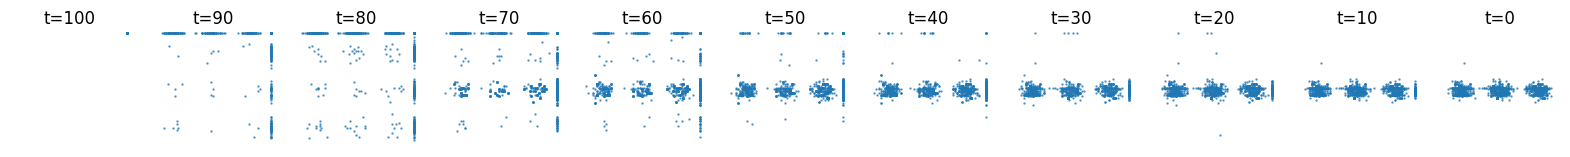

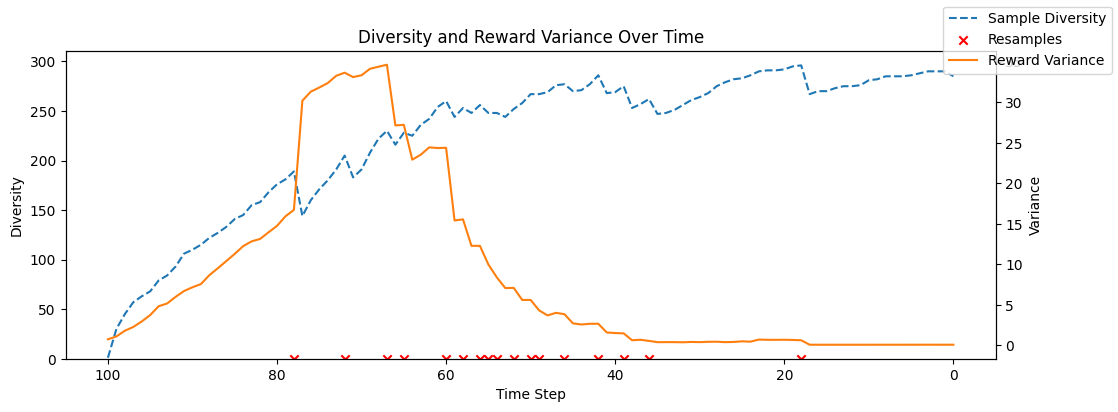

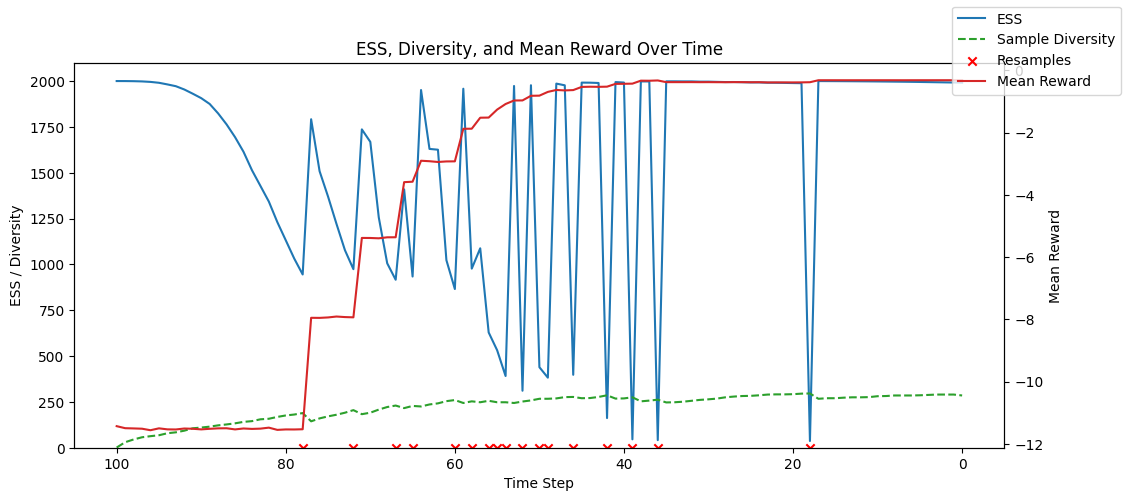

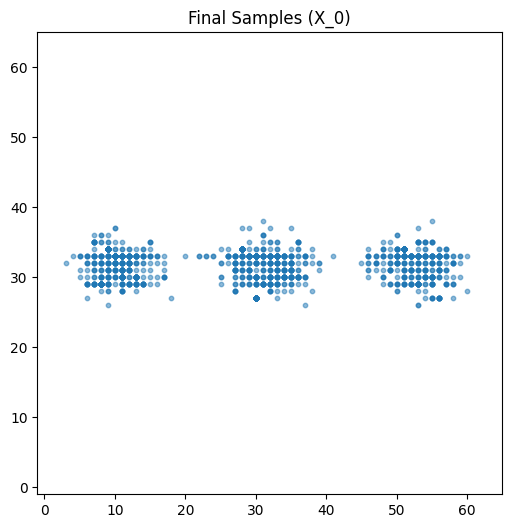

Final average reward: -0.3009
Final diversity: 277


In [13]:
plot_smc_results_checkerboard(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)

## First order approximate proposal with continuos formulation of subs parametrization

In [14]:
X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model_with_subs_continuous,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=ESS_min,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=first_order_approximation_optimal_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=reward_estimate_sample_count,
    device=device,
    verbose=False,
)

100%|██████████| 100/100 [00:02<00:00, 40.16it/s]

Resampled 5 times.


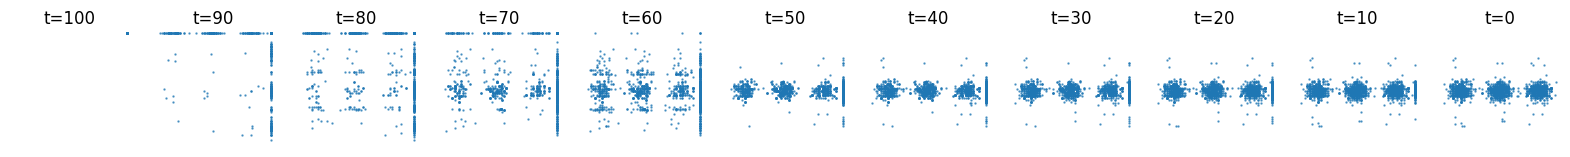

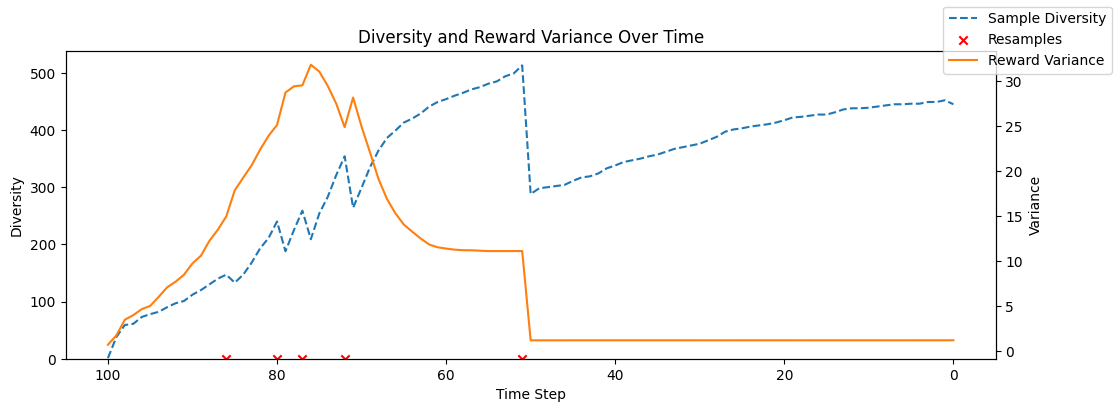

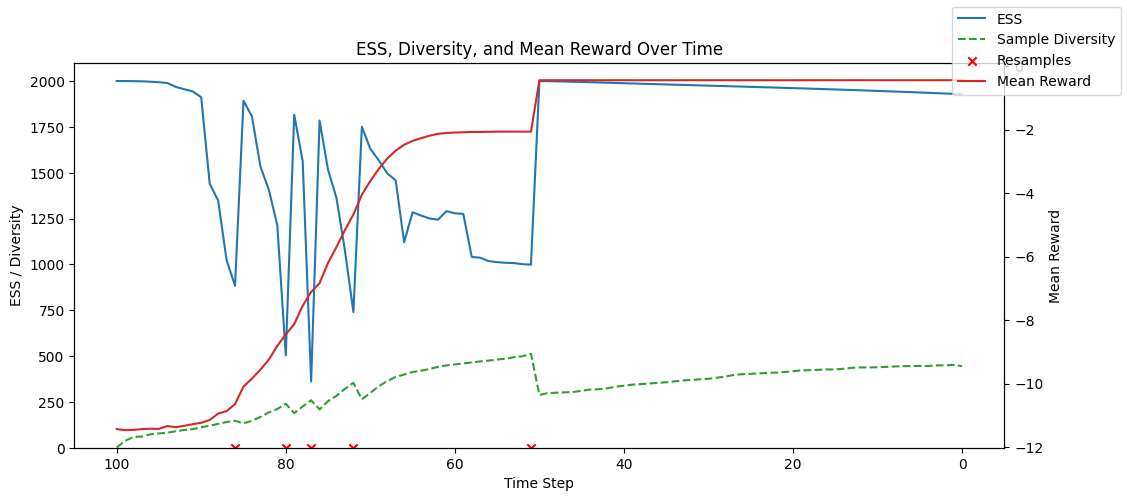

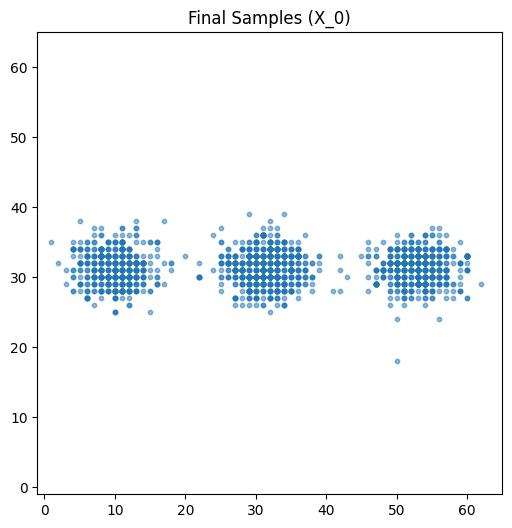

Final average reward: -0.2900
Final diversity: 389


In [15]:
plot_smc_results_checkerboard(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)

## Approximate Guidance

I am reusing the same SMC function for approximate guidance with a few tweaks. 
1. To avoid tempering, $\lambda_t$ is set to 1 for all $t$. 
2. To avoid resampling, `ESS_min` is set to -1. 
3. To avoid the final resampling step, set `perform_final_resample=False`.

With these changes, sampling using the first_order approxoimation optimal proposal is equivalent to sampling using approximate guidance.
$$
\log p(z_s| O, z_t) = \log p(z_s | z_t) + \log p(O | z_s, z_t) + c\\
$$
In approximate guidance, we approximate $p(O | z_s, z_t)$ as $\exp(\frac{1}{\alpha}\hat r (z_s))$. Substuting, we get:
$$
\log p(z_s| O, z_t) \approx \log p(z_s | z_t) + \frac{1}{\alpha}\hat r (z_s) + c\\
$$
Now, if we use first order Taylor's series approximation for $\hat r (z_s) = \hat r(z_t) + \nabla_{z_t} \hat r(z_t) (z_s - z_t)$, we get after absorbing constants into $c$:
$$
\log p(z_s| O, z_t) \approx \log p(z_s | z_t) + \frac{1}{\alpha} <\nabla_{z_t} \hat r(z_t), z_s> + c\\
$$
This is equivalent to the first order approximate proposal when $\lambda_t = 1$.

In [16]:
lambdas_no_tempering = torch.ones(len(lambdas))

### Without continuous formulation

100%|██████████| 100/100 [00:02<00:00, 38.72it/s]


Resampled 0 times.


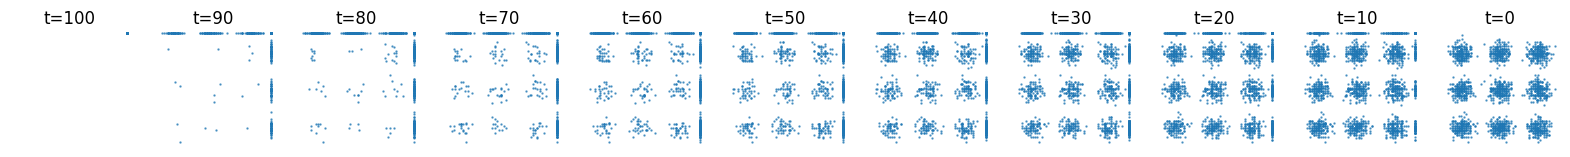

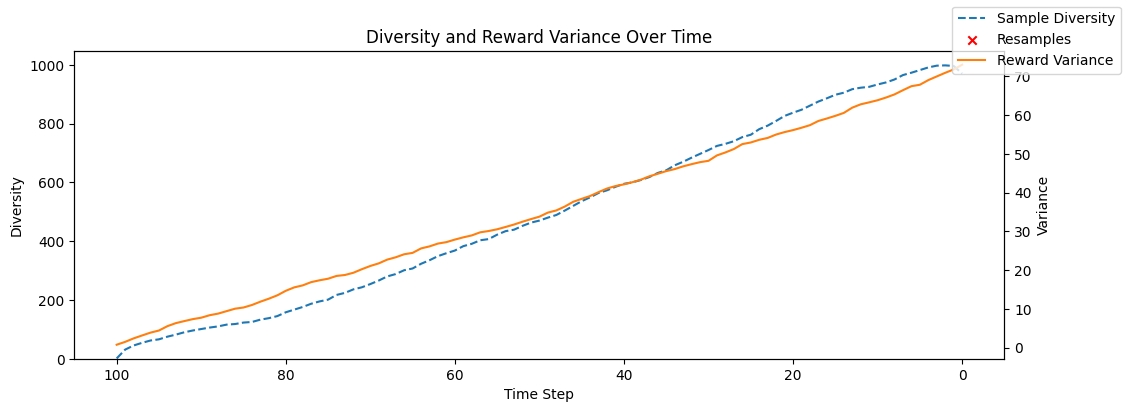

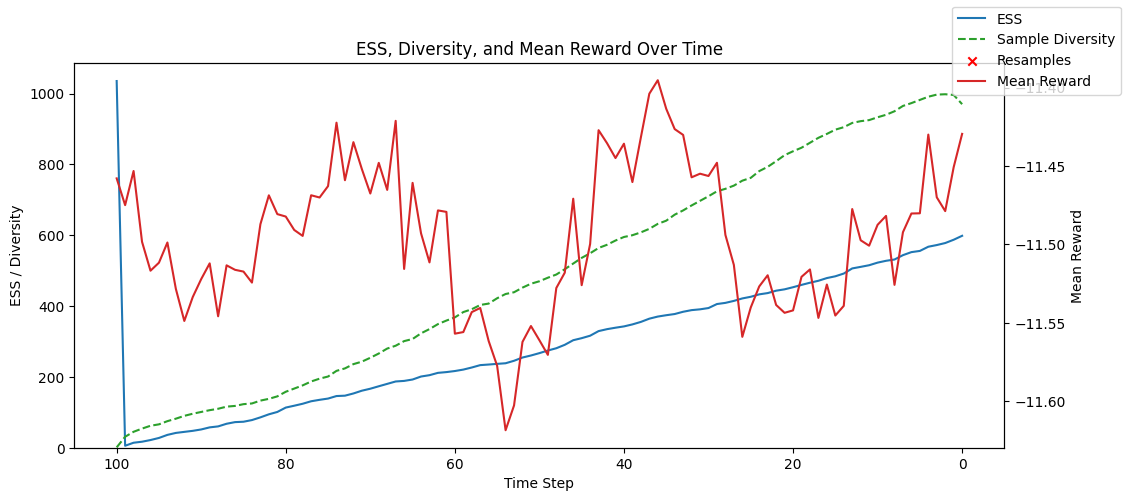

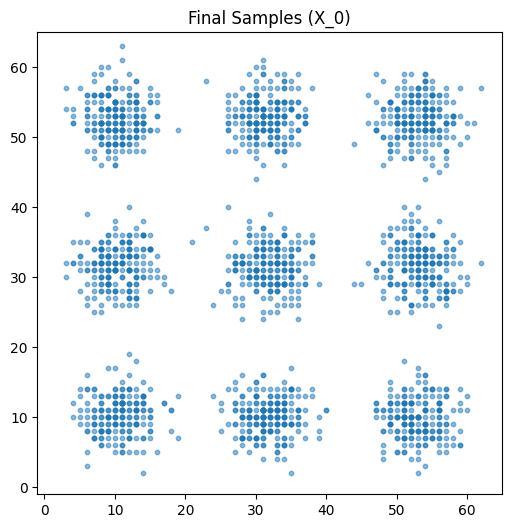

Final average reward: -11.4295
Final diversity: 970


In [17]:
X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=-1,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=first_order_approximation_optimal_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas_no_tempering,
    kl_weight=kl_weight,
    reward_estimate_sample_count=reward_estimate_sample_count,
    device=device,
    verbose=False,
    perform_final_resample=False,
)
plot_smc_results_checkerboard(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)

This is expected due to ill defined gradients. There is effectively no guidance when we use the discontinuous subs formualtion.

### With continuous subs formulation

100%|██████████| 100/100 [00:02<00:00, 37.89it/s]


Resampled 0 times.


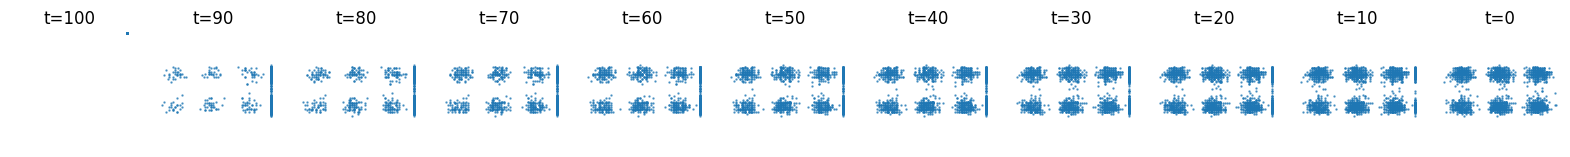

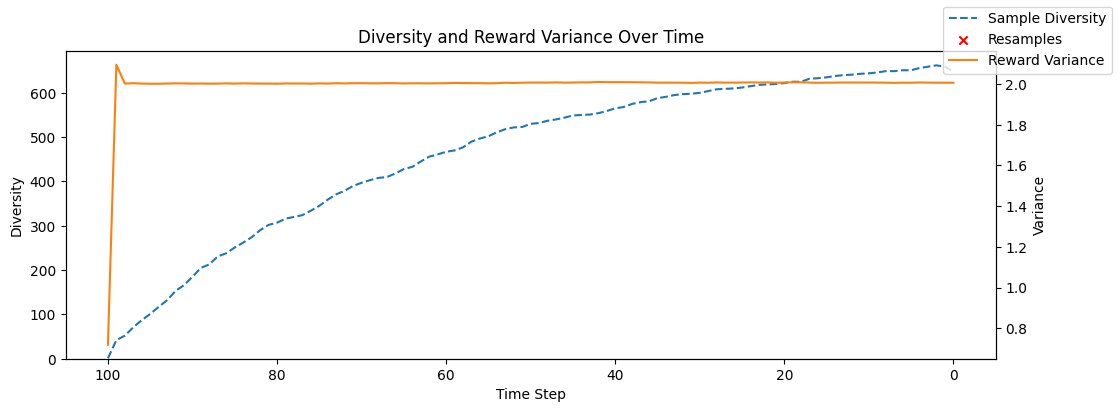

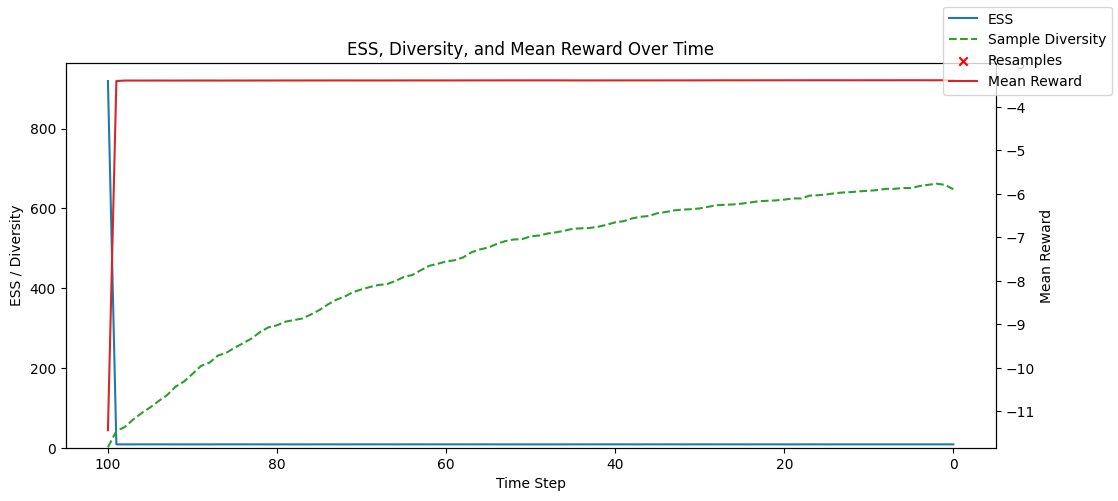

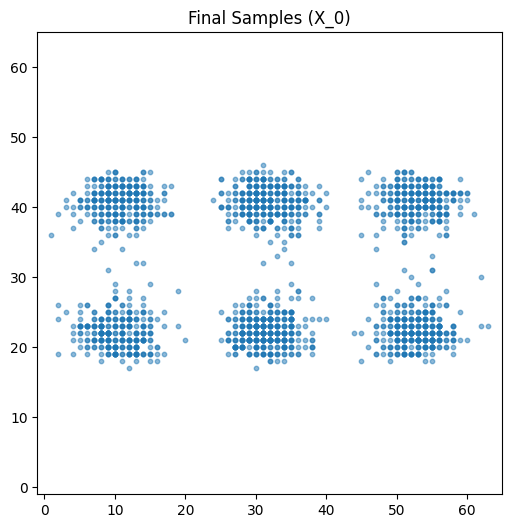

Final average reward: -3.3903
Final diversity: 648


In [18]:
X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model_with_subs_continuous,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=-1,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=first_order_approximation_optimal_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas_no_tempering,
    kl_weight=kl_weight,
    reward_estimate_sample_count=reward_estimate_sample_count,
    device=device,
    verbose=False,
    perform_final_resample=False,
)
plot_smc_results_checkerboard(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)

Interestingly, there are no points in the middle, where the reward is the highest. Explained this weird resulting distribution in another [notebook](../misc_scripts/explaining_approximate_guidance_results.ipynb).

### With tempering

100%|██████████| 100/100 [00:02<00:00, 37.34it/s]


Resampled 0 times.


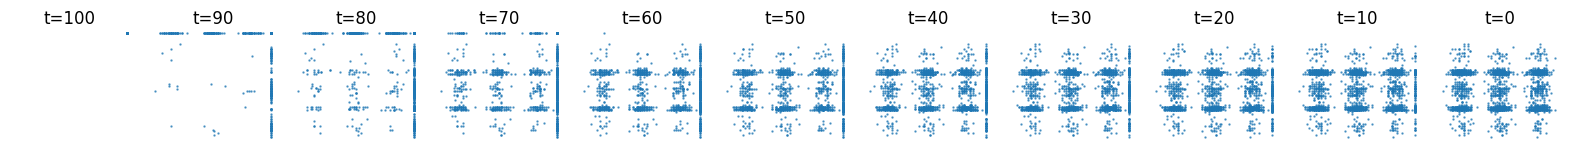

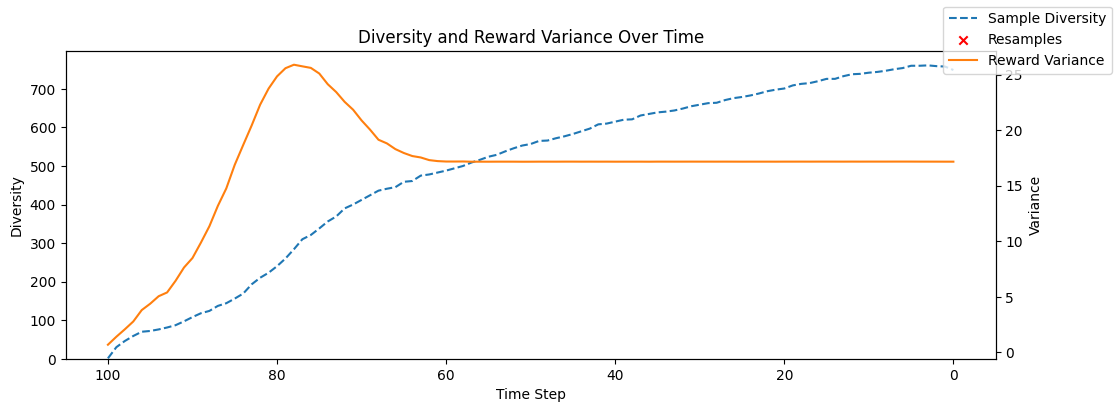

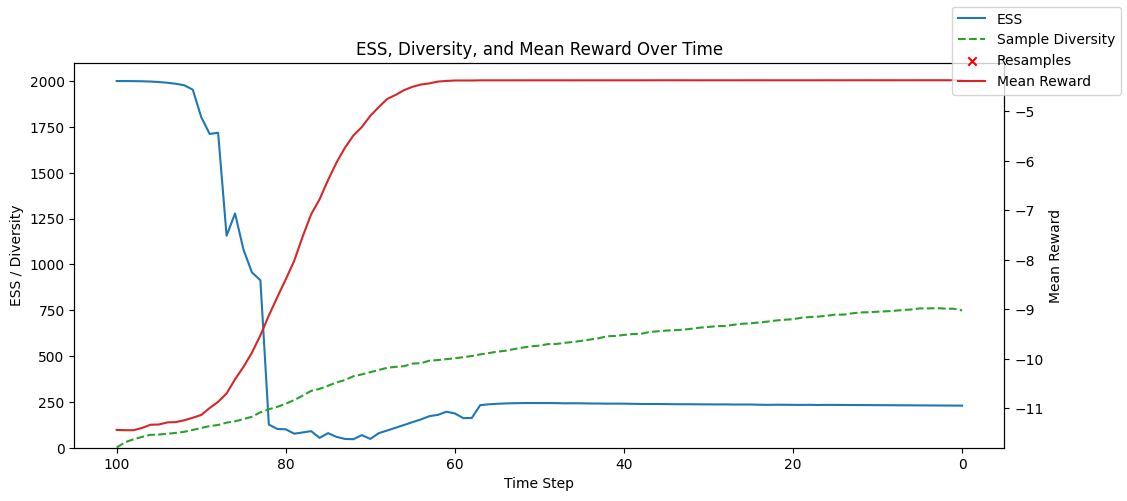

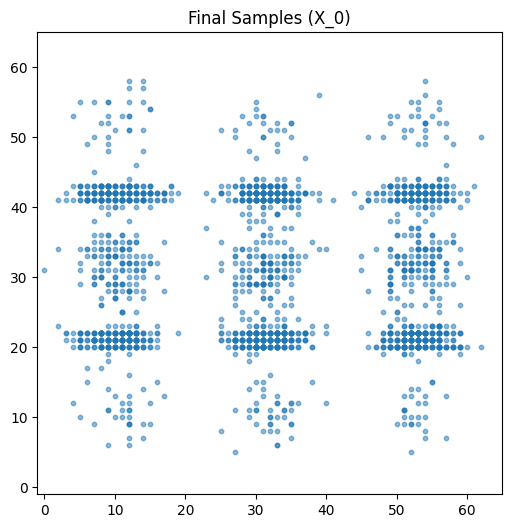

Final average reward: -4.3749
Final diversity: 749


In [19]:
X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace = sequential_monte_carlo(
    model=pretrained_model_with_subs_continuous,
    num_categories=num_categories,
    T=num_timesteps,
    N=num_particles,
    ESS_min=-1,
    intialize_particles_fn=intialize_particles,
    resample_fn=systematic_resample,
    proposal_fn=first_order_approximation_optimal_proposal,
    compute_reward_fn=compute_rewards,
    lambdas=lambdas,
    kl_weight=kl_weight,
    reward_estimate_sample_count=reward_estimate_sample_count,
    device=device,
    verbose=False,
    perform_final_resample=False,
)
plot_smc_results_checkerboard(X_0, W_0, ess_trace, rewards_trace, particles_trace, log_weights_trace, resampling_trace, num_timesteps, vocab_size, num_categories, compute_rewards)